<a href="https://colab.research.google.com/github/mmasliakova/Ribo-Seq-analysis/blob/main/Riboseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание 1. Определение дифференциальной экспрессии.**

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [139]:
data = pd.read_csv('01. RiboSeq_RNASeq_HCC_counts.tsv', sep='\t')
data = data.fillna(0)

In [140]:
genes = list(data["geneSymbol"])
del data["geneID"], data["geneSymbol"]
data.index = genes
data.head()

,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,LC034-tumor-RPF,...,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
TSPAN6,0,0,402,873,0,0,301,1627,0,0,...,218,457,0,0,200,889,0,0,161,857.0
TNMD,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.0
DPM1,168,239,88,187,114,439,66,201,325,117,...,92,170,109,357,60,244,141,173,56,83.0
SCYL3,65,121,60,106,36,163,70,156,130,76,...,127,176,67,176,55,261,64,100,68,176.0
C1orf112,8,43,18,70,16,76,4,63,44,14,...,124,437,7,167,34,201,6,61,9,58.0


**1.1 Нахождение коэффициента корреляции числа каунтов между экспериментами RNA-Seq и Ribo-Seq**

Я выбрала корреляцию Спирмена, так как зависимость между переменными нелинейна

In [141]:
corr = pd.DataFrame()

In [142]:
coef = []
from scipy import stats
for i in range(len(data)):
  x = [] #массив для каунтов Ribo-Seq i-того гена
  y = [] #массив для каунтов RNA-Seq i-того гена
  count = 0
  for col in range(1, 40, 2): #проход по датасету каунтов для корреляции методов
    if count % 2 == 0:
      x.extend((data.iloc[i, col - 1], data.iloc[i, col]))
    else:
      y.extend((data.iloc[i, col - 1], data.iloc[i, col]))
    count += 1
  coef.append(stats.spearmanr(x, y)[0])

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [143]:
data.index = genes
corr['spearman'] = coef
corr.index = genes
corr

,spearman
TSPAN6,NaN
TNMD,-0.139424
DPM1,0.849624
SCYL3,0.697779
C1orf112,0.811583
...,...
RP1-34B20.21,0.382301
RP11-511P7.5,0.191364
KLF18,NaN
TRBV6-2,NaN


### **1.2 Гистограмма распределения коэффициентов корреляции**

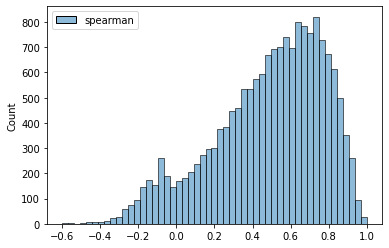

In [144]:
sns.histplot(data=corr)

In [145]:
corr_low = corr.sort_values('spearman', ascending = True)
corr_low.head()

,spearman
LAT,-0.599996
RPH3A,-0.588242
C14orf28,-0.587297
SOX8,-0.561372
REM2,-0.551351


Самая низкая корреляция для генов LAT, RPH3A, C14orf28, SOX8 и REM2

In [146]:
corr_high = corr.sort_values('spearman', ascending = False)
corr_high.head()

,spearman
TRIM60,1.0
RFPL4B,1.0
GAGE10,1.0
FAM46D,1.0
SCGB1D2,1.0


Самая высокая корреляция для генов TRIM60, RFPL4B, GAGE10, FAM46D и SCGB1D2

Посмотрев на каунты генов с высокой корреляцией видно, что большинство значений как для RNA-Seq, так и для Ribo-Seq нулевые. Поэтому получилась высокая корреляция числа каунтов. 

А для генов с низкой корреляции для все RNA-Seq экспериментов есть ненулевые значения, когда для Ribo-Seq почти все значения нулевые.

Биологический смысл в случае генов с низкой корреляцией может быть такой: так как для Ribo-Seq нулевые каунты, а для RNA-Seq нет, то после экспрессии РНК трансляция не проходит.

### **1.3 Распределение каунтов Ribo-seq**

In [147]:
rpf_data = data.filter(regex='RPF')
rpf_data.head()

,LC001-normal-RPF,LC001-tumor-RPF,LC033-normal-RPF,LC033-tumor-RPF,LC034-normal-RPF,LC034-tumor-RPF,LC501-normal-RPF,LC501-tumor-RPF,LC502-normal-RPF,LC502-tumor-RPF,LC505-normal-RPF,LC505-tumor-RPF,LC506-normal-RPF,LC506-tumor-RPF,LC507-normal-RPF,LC507-tumor-RPF,LC508-normal-RPF,LC508-tumor-RPF,LC509-normal-RPF,LC509-tumor-RPF
TSPAN6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TNMD,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0
DPM1,168,239,114,439,325,117,106,192,118,292,159,237,149,230,169,260,109,357,141,173
SCYL3,65,121,36,163,130,76,34,43,84,221,74,185,65,98,81,105,67,176,64,100
C1orf112,8,43,16,76,44,14,5,27,24,42,10,71,18,103,79,225,7,167,6,61


In [148]:
#расчет диспресии и среднего
rpf_data = rpf_data.loc[~rpf_data.index.duplicated(), :]
var = np.var(rpf_data, axis = 1)
mean = np.mean(rpf_data, axis = 1)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


[[]]

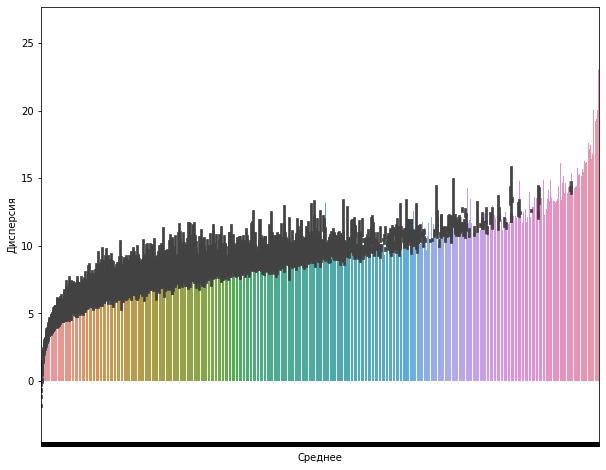

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Среднее')
ax.set_ylabel('Дисперсия')

xlog = np.log(mean)
ylog = np.log(var)

sns.barplot(xlog, ylog).set(xticklabels=[])

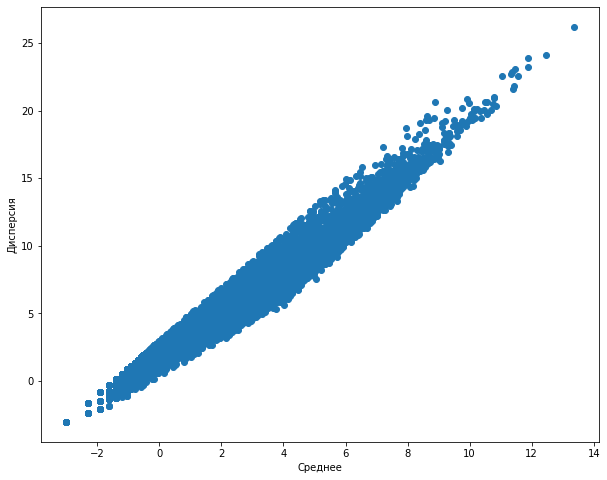

In [150]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Среднее')
ax.set_ylabel('Дисперсия')

plt.scatter(xlog, ylog)

Зависимость дисперсии от среднего похожа на NB-распределение

Для проверки можно использовать тест Колмогорова-Смирнова, но не уверена как тут можно проверить :(

Анализ дифференциальной экспрессии

In [151]:
design = pd.DataFrame({
    "condition": [sample.split("-")[1] for sample in data.columns],
    "experiment": [sample.split("-")[2] for sample in data.columns],
}, index=data.columns)

design.head()

,condition,experiment
LC001-normal-RPF,normal,RPF
LC001-tumor-RPF,tumor,RPF
LC001-normal-RNA,normal,RNA
LC001-tumor-RNA,tumor,RNA
LC033-normal-RPF,normal,RPF


In [152]:
design.to_csv('design.tsv', sep='\t') #файл для анализа дифф экспрессии в R

Дифференциально экспрессированные гены между опухолью и нормой для RNA-Seq эксперимента

In [153]:
rna_deseq = pd.read_csv('rna_deseq.tsv', sep = '\t')
rna_deseq = rna_deseq.iloc[:, 1:]
rna_deseq.index = genes
rna_deseq_sign = rna_deseq[rna_deseq.padj < 0.05].sort_values('padj') #только статистически значимые гены
rna_deseq_sign.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CLEC4G,187.902511,-6.224294,0.471543,-13.199842,8.791966e-40,1.464478e-35
OIT3,207.433311,-4.190143,0.372389,-11.252055,2.262593e-29,1.884400e-25
AVPR1A,216.785200,-4.836026,0.444956,-10.868551,1.627649e-27,8.917125e-24
INS-IGF2,517.466267,-5.941896,0.547969,-10.843493,2.141352e-27,8.917125e-24
FCN2,154.170314,-5.700993,0.527201,-10.813696,2.964778e-27,9.876861e-24


Наиболее дифференциально экспрессированные гены - CLEC4G, OIT3, AVPR1A, INS-IGF2, FCN2

Text(0, 0.5, 'log$_{10}$FDR')

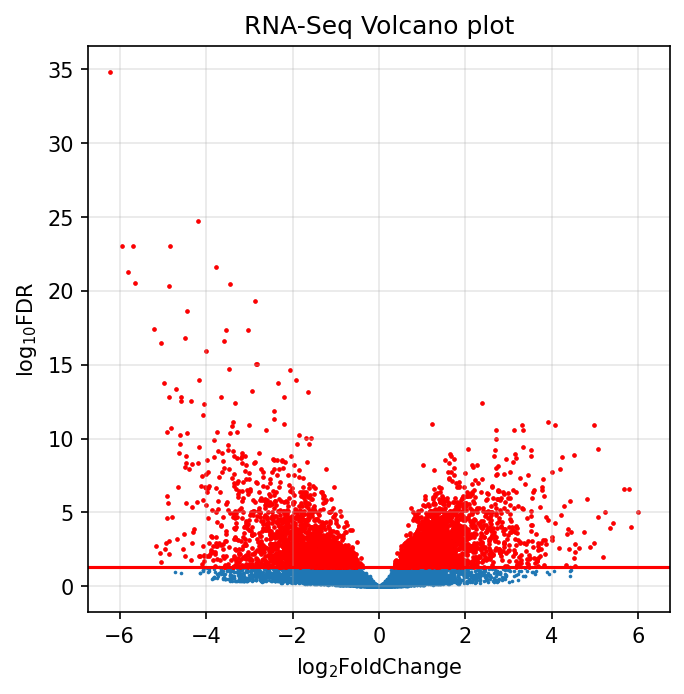

In [154]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(rna_deseq.log2FoldChange), (max(rna_deseq.log2FoldChange))) + 0.5

sns.scatterplot(
    x=rna_deseq.log2FoldChange,
    y=-np.log10(rna_deseq.padj),
    ax=ax,
    s=3,
    linewidth=0)

ax.plot(
    [-xlim, xlim],
    [-np.log10(0.05), -np.log10(0.05)],
    color="red")

sns.scatterplot(
    x=rna_deseq_sign.log2FoldChange,
    y=-np.log10(rna_deseq_sign.padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="red")

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_title('RNA-Seq Volcano plot')
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

In [155]:
rpf_deseq = pd.read_csv('rpf_deseq.tsv', sep = '\t')
rpf_deseq = rpf_deseq.iloc[:, 1:]
rpf_deseq.index = genes
rpf_deseq_sign = rpf_deseq[rpf_deseq.padj < 0.05].sort_values('padj')
rpf_deseq_sign.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CETP,234.706196,-3.661168,0.328144,-11.157205,6.603531e-29,9.219850e-25
OIT3,378.527099,-4.123941,0.384101,-10.736618,6.850819e-27,4.782557e-23
TIMD4,115.823325,-4.410428,0.424721,-10.384291,2.923339e-25,1.360522e-21
ADGRA3,351.272069,-3.789142,0.368147,-10.292473,7.619383e-25,2.659546e-21
CLEC4M,60.025648,-6.019149,0.589470,-10.211112,1.768264e-24,4.937702e-21


Наиболее дифференциально экспрессированные гены - CETP, OIT3, TIMD4, ADGRA3, CLEC4M

Text(0, 0.5, 'log$_{10}$FDR')

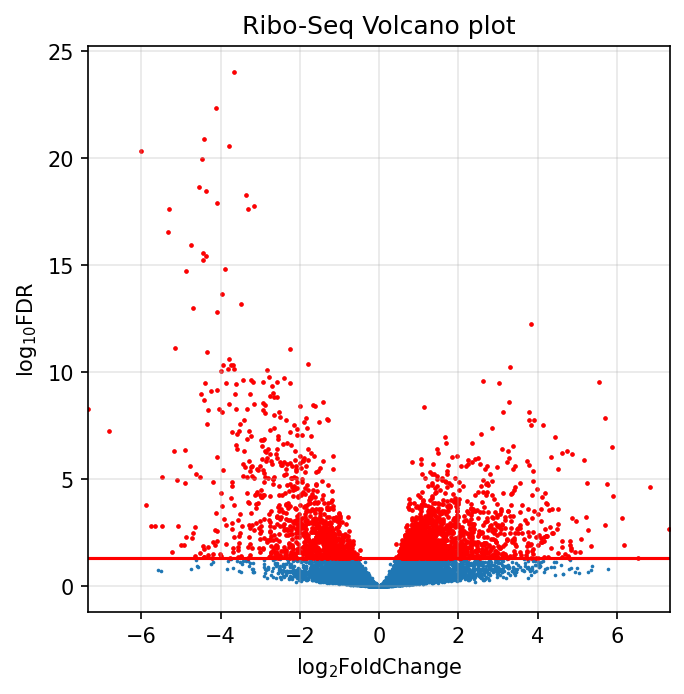

In [156]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
minn = sorted(set(rpf_deseq.log2FoldChange.to_list()))[1] 
#наименьшее значение равно nan, поэтому беру следующее наименьшее значение
maxx = sorted(set(rpf_deseq.log2FoldChange.to_list()))[-1] 
#наибольшее значение равно nan, поэтому беру следующее наибольшее значение

xlim = max(-minn, maxx) + 0.5

sns.scatterplot(
    x=rpf_deseq.log2FoldChange,
    y=-np.log10(rpf_deseq.padj),
    ax=ax,
    s=3,
    linewidth=0)

ax.plot(
    [-xlim, xlim],
    [-np.log10(0.05), -np.log10(0.05)],
    color="red")

sns.scatterplot(
    x=rpf_deseq_sign.log2FoldChange,
    y=-np.log10(rpf_deseq_sign.padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="red")

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_title('Ribo-Seq Volcano plot')
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

In [157]:
total_deseq = pd.read_csv('total_deseq.tsv', sep = '\t')
total_deseq = total_deseq.iloc[:, 1:]
total_deseq.index = genes
total_deseq_sign = total_deseq[total_deseq.padj < 0.05].sort_values('padj')
total_deseq_sign.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
UAP1,524.937253,-1.852040,0.372283,-4.974812,6.531085e-07,0.005695
DMXL1,292.358919,-1.242948,0.250249,-4.966847,6.805028e-07,0.005695
DPP9,19998.727349,2.699844,0.557605,4.841855,1.286329e-06,0.007176
CDC25A,28.822459,3.896988,0.820834,4.747594,2.058507e-06,0.008613
KIAA1211L,9.758817,3.937915,0.884599,4.451639,8.521747e-06,0.028526


В случае сравнения разных методов наиболее дифференциально экспрессированные гены - UAP1, DMXL1, DPP9, CDC25A, KIAA1211L

Text(0, 0.5, 'log$_{10}$FDR')

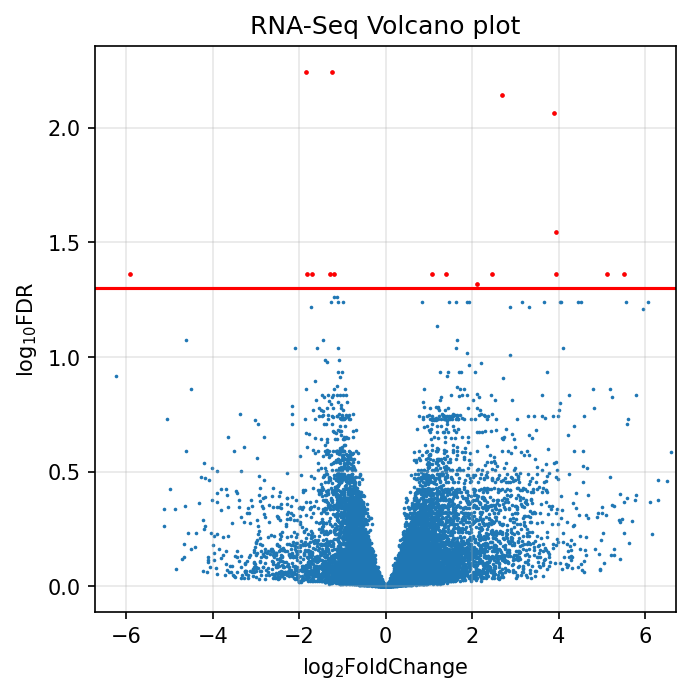

In [158]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
xlim = max(-min(rna_deseq.log2FoldChange), (max(rna_deseq.log2FoldChange))) + 0.5

sns.scatterplot(
    x=total_deseq.log2FoldChange,
    y=-np.log10(total_deseq.padj),
    ax=ax,
    s=3,
    linewidth=0)

ax.plot(
    [-xlim, xlim],
    [-np.log10(0.05), -np.log10(0.05)],
    color="red")

sns.scatterplot(
    x=total_deseq_sign.log2FoldChange,
    y=-np.log10(total_deseq_sign.padj),
    ax=ax,
    s=5,
    linewidth=0,
    color="red")

ax.grid(alpha=0.3)

ax.set_xlim(-xlim, xlim)
ax.set_title('RNA-Seq Volcano plot')
ax.set_xlabel("log$_2$FoldChange")
ax.set_ylabel("log$_{10}$FDR")

## **Задание 2. Анализ wig-файла.**

### **2.1 Неравномерность покрытия генома**

In [159]:
! sed -i -e '1d' 02.\ RiboSeq_EColi_track_f.wig
! head 02.\ RiboSeq_EColi_track_f.wig

77	2
85	1
139	1
147	1
153	1
155	1
159	1
173	1
176	6
182	2


In [160]:
! sed -i -e '1d' 02.\ RiboSeq_EColi_track_r.wig
! head 02.\ RiboSeq_EColi_track_r.wig

1212	1
1292	1
3626	1
3979	1
4408	1
4797	1
4916	1
4952	1
4979	1
5183	1


In [161]:
counts_f = pd.read_csv('02. RiboSeq_EColi_track_f.wig', sep = '\t', names = ['coordinate', 'counts'])
counts_r = pd.read_csv('02. RiboSeq_EColi_track_r.wig', sep = '\t', names = ['coordinate', 'counts'])

In [162]:
counts = pd.concat([counts_f, counts_r], axis=0, ignore_index=True)
counts = counts.sort_values('coordinate', ascending = True)
counts = counts.reset_index(drop = True)
counts.head()

,coordinate,counts
0,77,2
1,85,1
2,139,1
3,147,1
4,153,1


In [163]:
#при склеивании данных прямых и обратных ридов координаты повторяются - суммирую их
duplicate = counts[counts.duplicated('coordinate')]
for i in range(len(duplicate)):
  coord = duplicate.iloc[i, 0]
  count = duplicate.iloc[i, 1]
  index = (counts.coordinate.values == coord).argmax()
  counts.iloc[index, 1] += count

In [164]:
counts = counts.drop_duplicates(subset=['coordinate'])

In [173]:
! mv GCF_000005845.2_ASM584v2_genomic.gff annotation.gff

In [174]:
! sed -i -e '1, 7d' annotation.gff

In [175]:
! head annotation.gff

NC_000913.3	RefSeq	region	1	4641652	.	+	.	ID=NC_000913.3:1..4641652;Dbxref=taxon:511145;Is_circular=true;Name=ANONYMOUS;gbkey=Src;genome=chromosome;mol_type=genomic DNA;strain=K-12;substrain=MG1655
NC_000913.3	RefSeq	gene	190	255	.	+	.	ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:EG11277,GeneID:944742;Name=thrL;gbkey=Gene;gene=thrL;gene_biotype=protein_coding;gene_synonym=ECK0001;locus_tag=b0001
NC_000913.3	RefSeq	CDS	190	255	.	+	0	ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=UniProtKB/Swiss-Prot:P0AD86,Genbank:NP_414542.1,ASAP:ABE-0000006,ECOCYC:EG11277,GeneID:944742;Name=NP_414542.1;gbkey=CDS;gene=thrL;locus_tag=b0001;orig_transcript_id=gnl|b0001|mrna.NP_414542;product=thr operon leader peptide;protein_id=NP_414542.1;transl_table=11
NC_000913.3	RefSeq	gene	337	2799	.	+	.	ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:EG10998,GeneID:945803;Name=thrA;gbkey=Gene;gene=thrA;gene_biotype=protein_coding;gene_synonym=ECK0002,Hs,thrA1,thrA2,thrD;locus_tag=b0002
NC_000913.3	RefSeq	CDS	337	2799	.	

In [179]:
import re
annotation = pd.read_csv('annotation.gff', sep = '\t')
annotation.drop(9482, inplace = True)
annotation.drop(annotation.columns[[0, 1]], axis = 1, inplace = True)
annotation = annotation[annotation.region == 'gene']
annotation.drop(annotation.columns[[0, 3, 4, 5]], axis = 1, inplace = True)
annotation.columns = ['start', 'end', 'gene_info']
annotation = annotation.astype({'start': int, 'end': int, 'gene_info': str})
annotation = annotation.reset_index(drop = True)
for s in range(len(annotation)):
  gene = annotation['gene_info'][s]
  operon = re.search(';Name=(.*);gbkey', gene) #отбор генов из atp оперона
  res = operon.group(1) 
  annotation['gene_info'][s] = res

<ipython-input-179-4bc484bfb9db>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation['gene_info'][s] = res


In [180]:
df = {'coordinate': [0] * 4494, 'counts': [0] * 4494, 'counts_mean': [0] * 4494, 'gene_length': [0] * 4494}
counts_df = pd.DataFrame(df)
for i in range(len(annotation)): #запись в датафрейм данных о генах и их координатах
  start = annotation.iloc[i, 0]
  end = annotation.iloc[i, 1]
  gene_counts = counts[(counts['coordinate'] >= start) &  (counts['coordinate'] <= end)]
  gene_counts = gene_counts.reset_index(drop = True)
  num = gene_counts['counts'].sum()
  mean = num/len(gene_counts)
  counts_df.iloc[i, 0] = start
  counts_df.iloc[i, 1] = num
  counts_df.iloc[i, 2] = mean
  counts_df.iloc[i, 3] = end - start + 1

<ipython-input-180-b8641b671bc6>:9: RuntimeWarning: invalid value encountered in long_scalars
  mean = num/len(gene_counts)


In [181]:
counts_df.head()

,coordinate,counts,counts_mean,gene_length
0,190,811,16.551020,66
1,337,34300,17.958115,2463
2,2801,6706,10.678344,933
3,3734,19619,18.578598,1287
4,5234,160,2.424242,297


На примере гена с индексом 4492

In [182]:
counts_gene4492 = counts[(counts['coordinate'] >= 4640718) &  (counts['coordinate'] <= 4640771)]
counts_gene4492 = counts_gene4492.reset_index(drop = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

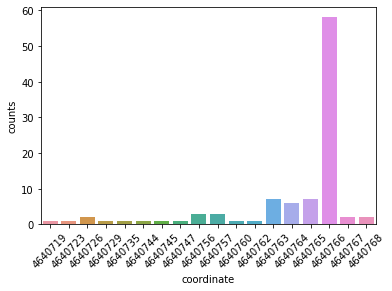

In [183]:
sns.barplot(data = counts_gene4492, x ='coordinate', y = 'counts')
plt.xticks(rotation=45)

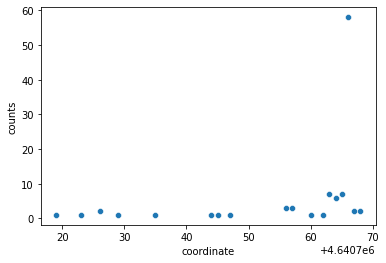

In [184]:
sns.scatterplot(data = counts_gene4492, x ='coordinate', y = 'counts')

Для всех генов

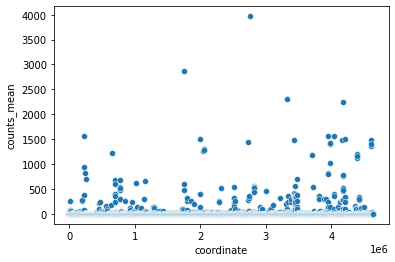

In [185]:
sns.scatterplot(data = counts_df, x = 'coordinate', y = 'counts_mean')

И для одного гена и для всех видна сильная неравномерность в покрытии

### **2.2 Расчет значений RPKM и TPM**

RPKM - значения каунтов, нормированное на глубину библиотеки и затем длину гена.

TPM - значения каунтов, нормированные на длину гена и затем глубину библиотеки.

Поэтому из-за разницы в порядке нормировки получаются разные значения

In [186]:
total_reads = counts_df.counts.sum()
RPKM = []
TPM = []
summ = 0
for i in range(len(counts_df)):
  RPKM.append(10**9 * (counts_df['counts'][i]/(total_reads * counts_df['gene_length'][i])))
  summ += (counts_df['counts'][i]/counts_df['gene_length'][i])

for i in range(len(counts_df)):
  TPM.append(10**6 * ((counts_df['counts'][i]/counts_df['gene_length'][i])/summ))
counts_df['RPKM'] = RPKM
counts_df['TPM'] = TPM


In [187]:
counts_df

,coordinate,counts,counts_mean,gene_length,RPKM,TPM
0,190,811,16.551020,66,208.081136,126.253658
1,337,34300,17.958115,2463,235.822641,143.085874
2,2801,6706,10.678344,933,121.713205,73.849738
3,3734,19619,18.578598,1287,258.139290,156.626547
4,5234,160,2.424242,297,9.122615,5.535165
...,...,...,...,...,...,...
4489,4638178,30,1.071429,1353,0.375473,0.227819
4490,4639590,11509,19.980903,717,271.815505,164.924618
4491,4640402,66,1.941176,141,7.926484,4.809411
4492,4640718,99,5.500000,54,31.045398,18.836859


### **2.3 Анализ значений RPKM для генов из оперона ATP**

In [188]:
atp = annotation[annotation['gene_info'].str.contains('atp')]

In [189]:
atp_rpkm = counts_df['RPKM'][(counts_df['coordinate'] >= 3915553) & (counts_df['coordinate'] <= 3922440)]

In [190]:
atp['RPKM'] = atp_rpkm

<ipython-input-190-041b86e6346a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atp['RPKM'] = atp_rpkm


In [191]:
atp

,start,end,gene_info,RPKM
3810,3915553,3915972,atpC,466.729250
3811,3915993,3917375,atpD,1030.222326
3812,3917402,3918265,atpG,247.304815
3813,3918316,3919857,atpA,803.139055
3814,3919870,3920403,atpH,299.386720
3815,3920418,3920888,atpF,454.158034
3816,3920950,3921189,atpE,5037.468549
3817,3921236,3922051,atpB,475.289266
3818,3922060,3922440,atpI,22.711808


Координаты оперона: 3915553-3922440

Гены: atpC, atpD, atpG, atpA, atpH, atpF, atpE, atpB, atpI

Между генами одного оперона есть разница между значениями RPKM, при этом для некоторых генов очень большая

Наибольшее значение RPKM соответствует очень консервативному гену atpE, кодирующему C-субъединицу АТФ-синтазы. Возможно из-за его функциональной значимости, он сильно транслируется, поэтому для этого гена покрытие высокое. 

Для гена atpI значение RPKM минимально в этом опероне - функции гена atpI менее обширны, он транслируется меньше. 

С помощью RNA-Seq неравномерность покрытия в опероне, скорее всего, была бы сильно меньше. Нельзя было бы увидеть точные данные с транслируемых областей.